# PyOptSparse\SNOPT

`1013.20.Apr`

The previous notebook was getting a bit long/confuddled, so I broke off with a clean slate on this attempt.

### Load header files, plot a random array of turbines

`1035.20.Apr.20`

In [4]:
#- Load all previously written and tested functions -#
import random

%run "baker_cs34_functions_sandbox.py"
%run "baker_cs34_SNOPT_functions.py"
%run "iea37_aepcalc.py"

In [5]:
#--- Load boundary, turb attributes, and windrose data ---#
#-- Load the Boundary --#
fn = "iea37-boundary-cs3.yaml"
bndryPts = getTurbAtrbtCs3YAML(fn)      # Pull the boundary vertices
clsdBP = closeBndryList(bndryPts)       # repeat the first so it's 'closed'
cncvVerts = makeSimpleCs3Bndry(clsdBP)  # Make the simplified Concave shape
cncvNorms = bndryNormals(cncvVerts)     # Calculate the normals for the concave shape
#- Load the turbine and windrose atributes -#
fname_turb = "iea37-10mw.yaml"
fname_wr = "iea37-windrose-cs3.yaml"
wind_dir, wind_dir_freq, wind_speeds, wind_speed_probs, num_speed_bins, min_speed, max_speed = iea37aepC.getWindRoseYAML(fname_wr)
turb_ci, turb_co, rated_ws, rated_pwr, turb_diam = iea37aepC.getTurbAtrbtYAML(fname_turb)
fAEPscale = 1.0
fTCscale = 1.0
#- Make a dictionary for variable passing -#
dictParams = makeParamsDict(wind_dir_freq, wind_speeds, wind_speed_probs, wind_dir, turb_diam, turb_ci, turb_co, rated_ws, rated_pwr, fAEPscale, fTCscale, cncvNorms, cncvVerts)

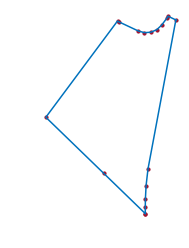

In [27]:
printBoundaryClr(clsdBP, 5)
printTurbines(bndryPts, getPltClrs().getColor(1), 10)
plt.savefig("./figures/cs3original.pdf")

In [43]:
#-- Make boundary splines and random turbine locations--#
#-- Spline the boundary --#
vertexList = [0, 6, 8, 9, 18]       # Hard code the vertices (though this could be done algorithmically)
numSides = len(vertexList) - 1      # The number of sides for our original coordinate system. Usually (4) to Euclidean, but could be any number)
splineList = np.empty(numSides, interp1d)                  # Init. array IOT save the Splines for each "side"
buf = np.zeros((numSides, numGridLines, 2))                # Used to initalize the recarray to zeros
segCoordList = np.recarray([numSides, numGridLines], dtype=coordinate, buf=buf)

#- Create the splines for each side (<numSides> many)-#
for i in range(numSides):
    BndPts = clsdBP[vertexList[i]:(vertexList[i+1]+1)]      # Extract the points for the "edge" we want
    segCoordList[i] = sliceBoundary(BndPts, numGridLines)    # Reparameterize the boundry to be defined by <numGridLines> many points
    splineList[i] = interp1d(segCoordList[i].x, segCoordList[i].y, kind='linear')   # Make the spline using NumPy's <interp1d>

#-- Make random turbine locations --#
vertexPts = bndryPts[vertexList[0:4]]  # Make an array of just the four "vertex" points we're using
turbRandoList = iea37cs3randomstarts(numTurbs, splineList, vertexPts, turb_diam)
randoMatrix = makeCoordMatrix(turbRandoList)    # Use the random locations calculated previously

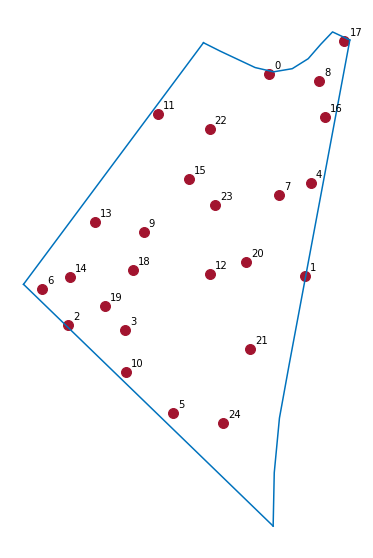

In [44]:
#-- Plot splined boundary and random (numbered) turbine locations --#
#- Display data/constants -#
displaySize = np.recarray(1, coordinate)
displaySize.x = 10
displaySize.y = 10
numLinspace = 10
numGridLines = 10                   # How many gridlines we'll use for the visualization
printOffset = (5, 5)

#- Plot the boundary -#
for i in range(numSides):
    plt.hold = True
    printBoundaryArray(segCoordList[i].x, splineList[i](segCoordList[i].x), displaySize, 5)

#- Plot the turbine locations -#
printTurbines(turbRandoList, getPltClrs().getColor(1), turb_diam/2)
for i in range(len(turbRandoList)):         # Number the turbines
    plt.annotate(i, (turbRandoList[i].x, turbRandoList[i].y), xytext=printOffset, textcoords='offset points')


### PyOptSparse/SNOPT setup (Dr. Ning's method)

`1036.20.Apr.20`

To be honest, this is a tricky way of still having all of the turbine attributes just global. It is not the solution I am looking for, but due to time constraints I just need to work with what I have and keep moving forward (meaning keep the values global)

**Example by Dr. Ning**

`1031.16.Apr.20`

```python
def f(x, params):
   ...
end

def runopt():
    params = ...
    function g(x) = f(x, params)
    optimize(g, x0)
end```

In [45]:
#-- Working the wrapper method --#
def f(ParamsDict):
    # To follow Dr. Ning's rubric
    return lambda x0: iea37aepC.calcAEPcs3(x0, ParamsDict['wind_dir_freq'], \
                               ParamsDict['wind_speeds'], \
                               ParamsDict['wind_speed_probs'], \
                               ParamsDict['wind_dir'], \
                               ParamsDict['turb_diam'], \
                               ParamsDict['turb_ci'], \
                               ParamsDict['turb_co'], \
                               ParamsDict['rated_ws'], \
                               ParamsDict['rated_pwr'])

g = f(dictParams)
#print(g(turbCoords))

In [81]:
#- pseudocode for objfun() setup -#
#def objfunc(xdict):A
#    x0 = xdict['turbCoords']
#    funcs = {}
#    funcs['obj'] = getAEP(x0, params)
#    funcs['con'] = getTurbSpacing(x0)
#    fail = False

#    return funcs, fail

#-- Setting up objFun --#
def cs3posObjFun(posDict):
    #- Target function (AEP calculation) -#
    
    x0m = makeArrayMatrix(posDict['aTurbCoords'])  # Take our turbine array [x1 ... y1...] and make a matrix
    nTurbs = len(x0m) # get the number of turbines
    nPairs = int(binom(nTurbs, 2)) # Number of unique turbine pairs
    funcs = {}
    AEP = g(x0m)         # Our tricky global function
    totAEP = np.sum(AEP)
    funcs['obj'] = - (totAEP)# / fScaleFactorAEP) # Negative to minimize
    
    #- Prep data for constraints -#
    #fScaleFactorTurbLoc = posDict['fTCscale']
    x0s = makeArrayCoord(posDict['aTurbCoords'])
    [fNormVals,__] = calcDistNorms(x0s, dictParams['cncvVerts'], dictParams['cncvNorms'])
    funcs['bndry'] = fNormVals.flatten()
    fTurbSpace,__ = checkTurbSpacing(x0s, dictParams['minTurbSpace'])
    funcs['spacing'] = fTurbSpace
    
    #- Constraints (Pairwise distance [C(numTurbs, 2)], and all boundary checks [4* numTurbs]) -#
    #nBndryCnstr = nTurbs * 4 # each turbine (25) has one constraint for each boundary (4)
    #nSpaceCnstr = nPairs
    #conval = [0]*(nBndryCnstr + nSpaceCnstr)
    # List all the boundary and spacing constraints
    #conval = np.concatenate(cnstrSpacing, nBndryCnstr)
    #funcs['con'] = conval
    
    fail = False

    return funcs, fail

In [82]:
#--- Running the optimization ---#
#- Constants --#
nNumTurbs = len(turbRandoList)    # Number of turbines we're passed
nNumPairs = int(binom(nNumTurbs, 2)) # Number of unique turbine pairs

#-- Setup optimization --#
optProb = Optimization('CaseStudy3', cs3posObjFun)
optProb.addObj('obj')
#-- Setup variables to alter (turbine locations) --#
x0rando =makeCoordArray(turbRandoList)   # Make our coordinate list an array
optProb.addVarGroup('aTurbCoords', 2*nNumTurbs, type='c', value= x0rando) # two (2) values for each turbine (x&y)

#-- Boundary constraints (setup to stay positive) --#
optProb.addConGroup('bndry', 4*nNumTurbs, lower=0.0, upper=None) # 4 boundaries to chek for each turbine
#-- Spacing constraint (setup to stay positive) --#
optProb.addConGroup('spacing', nNumPairs, lower=0.0, upper=None)

#-- Run the actual optimization --#
opt = SNOPT()
opt.setOption('Scale option',1)
opt.setOption('Iterations limit',1000000)
opt.setOption('Major optimality tolerance',1.e-5)
opt.setOption('Major feasibility tolerance',1.e-6)
#opt.setOption('Print file', 'print_file.out')
#opt.setOption('Summary file','summary_file.out')

#print(optProb)

In [83]:
sol = opt(optProb)
print(sol)


+------------------------------------------------------------------------------+
| pyOptSparse Error: Failed to properly open SNOPT_print.out, ierror = 5002    |
+------------------------------------------------------------------------------+



Error: 

`21.Apr.20`

Jared suggests taking it out of the jupyter notebook and just running a script, due to possible permission errors.

### Variable Manipulation fixes

`1211.20.Apr,20`

I just realized my variable manipulation functions werte a bit messed up. Some concatenated [x1, x2, ... xn, y1, y1, ... yn] and others used [x1, y1, x2, y2, ...]. I changed everything to work in the former first method. Following are function tests.

In [39]:
print(turbRandoList[0])
testA = makeCoordArray(turbRandoList)
testB = makeArrayCoord(testA)
print(testB[0])

(9162.5409912, 5090.14498131)
(9162.5409912, 5090.14498131)


In [33]:
print(turbRandoList[0])
testA = makeCoordArray(turbRandoList)
testC = makeArrayMatrix(testA)
print(testC[0])

(9162.5409912, 5090.14498131)
[9162.5409912  5090.14498131]


In [40]:
print(turbRandoList[0])
testD = makeCoordMatrix(turbRandoList)
print(testD[0])
testE = makeMatrixCoord(testD)
print(testE[0])

(9162.5409912, 5090.14498131)
[9162.5409912  5090.14498131]
(9162.5409912, 5090.14498131)
